# Clasificacion de IDC con CNN

## Librerias y Paquetes

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from glob import glob  #El módulo glob puede obtener la ruta completa de todos los archivos elegibles de acuerdo con la ruta especificada
from skimage.io import imread
from os import listdir

import time  #contiene una serie de funciones relacionadas con la medición del tiempo
import copy  #permite crear copias de distintos objetos de Python
from tqdm import tqdm_notebook as tqdm  #Instantly make your loops show a smart progress meter

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.utils import get_file


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from imblearn.metrics import sensitivity_score, specificity_score

import os
import zipfile
import random

## Configuraciones

In [2]:
run_training = False
retrain = False
find_learning_rate = False

## Cargamos el Data Set

In [3]:
files = listdir(
    "C:/Users/juanS/OneDrive/Escritorio/Master IMF/TFM/TFM DS/Data Set")
print(len(files))

132


In [4]:
files[0:10]

['12877',
 '12878',
 '12879',
 '12880',
 '12881',
 '12882',
 '12883',
 '12884',
 '12886',
 '12890']

In [5]:
base_path = "C:/Users/juanS/OneDrive/Escritorio/Master IMF/TFM/TFM DS/Data Set/IDC_regular_ps50_idx5"
folder = listdir(base_path)
len(folder)

279

In [6]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + "/" + patient_id
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [7]:
total_images

277524

In [8]:
data = pd.DataFrame(index=np.arange(0, total_images),
                    columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + "/" + patient_id
    for c in [0, 1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1

data.head()

,patient_id,path,target
0,10253,C:/Users/juanS/OneDrive/Escritorio/Master IMF/...,0
1,10253,C:/Users/juanS/OneDrive/Escritorio/Master IMF/...,0
2,10253,C:/Users/juanS/OneDrive/Escritorio/Master IMF/...,0
3,10253,C:/Users/juanS/OneDrive/Escritorio/Master IMF/...,0
4,10253,C:/Users/juanS/OneDrive/Escritorio/Master IMF/...,0


Ahora estamos en condiciones de mapear el patch de cada paciente con su ID

In [9]:
data.shape

(277524, 3)

**Las visualizaciones previas, asi como el EDA y la estadistica descriptiva elaborada para el data set, se encuentra en el notebook "exploratoryAnalysis.ipynb". Con el proposito de no repetir lineas y complicar la lectura del interesado.**

## Ingenieria de variables

**Ahora discriminamos las imagenes que poseen IDC y las que no poseen.**

In [10]:
data.target = data.target.astype(np.int)

In [11]:
# 1 == CANCERIGENAS
pos_selection = np.random.choice(data[data.target == 1].index.values,
                                 size=50,
                                 replace=False)

# 0 == NO CANCERIGENAS
neg_selection = np.random.choice(data[data.target == 0].index.values,
                                 size=50,
                                 replace=False)

In [12]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,
                                  "x"].str.replace("x", "",
                                                   case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,
                                  "y"].str.replace("y", "",
                                                   case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df


def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + "/" + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:, "x"].str.replace(
        "x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:, "y"].str.replace(
        "y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

ahora tenemos las coordenadas de cada parche, su ruta para cargar la imagen y su información de destino.

In [13]:
data.head()
#  ## /////////////////////////////////////////////////////////////////////////////////////////////////
data.loc[:, "target"] = data.target.astype(np.bool)  # aca cambie el type a bool
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 6.6+ MB


**En la siguiente linea se especifica el numero de pacientes que se quiere tomar como volumen de datos.**

In [14]:
patients = data.patient_id.unique()[0:60]

In [15]:
print(len(patients))

60


**Por lo general, asigno el 80% del conjunto de datos para entrenamiento y el otro 20% para pruebas. En este caso, como se mencionó anteriormente, la validación es crucial. Por lo tanto, asignaré el 70% para el entrenamiento del modelo , el 15% para las pruebas y el 15% para la validación.**

In [16]:


train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids,
                                     test_size=0.5,
                                     random_state=0)

**Observemos la distribucion porcentual de los conjuntos de datos**

In [17]:
print(
    len(train_ids) / patients.shape[0] * 100,
    len(dev_ids) / patients.shape[0] * 100,
    len(test_ids) / patients.shape[0] * 100)

70.0 15.0 15.0


In [18]:
print(len(train_ids), len(dev_ids), len(test_ids))

42 9 9


In [19]:
# Validation set is used for determining the parameters of the model

train_df = data.loc[data.patient_id.isin(train_ids), :].copy()
test_df = data.loc[data.patient_id.isin(test_ids), :].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids), :].copy()

# extract cords esta definida mas arriba
train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

**Observemos la cantidad de imagenes de entrenamiento y de validacion que poseemos**

In [20]:

n_training_samples = len(train_df)
n_validation_samples = len(dev_df)
print("Number of training samples:", n_training_samples)
print("Number of validation samples:", n_validation_samples)
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["path"], train_df["target"]))
valid_ds = tf.data.Dataset.from_tensor_slices(
    (dev_df["path"], dev_df["target"]))

## from_tensor_slices() method, we can get the slices of an array in the form of objects by using tf. data -- aplica una transformacion

Number of training samples: 54484
Number of validation samples: 10001


**El siguiente código usa el método map() para ejecutar la función process_path() en cada muestra en ambos conjuntos, básicamente cargará las imágenes, decodificará el formato de la imagen, convertirá los píxeles de la imagen para que estén en el rango [0, 1] y cambiará el tamaño a (299, 299, 3), luego tomamos una imagen e imprimimos su forma:**

In [21]:
# preprocess data
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3) # canales rgb
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [299, 299])  ## este tamaño es requerido por la red inception V3


def process_path(filepath, label):
    # load the raw data from the file as a string
    img = tf.io.read_file(filepath)
    img = decode_img(img)
    return img, label


valid_ds = valid_ds.map(process_path)  # map procesa una transformacion (process_path) al objeto iterable
train_ds = train_ds.map(process_path)
# test_ds = test_ds
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (299, 299, 3)
Label: False


**InceptionV3 requiere un formato (299, 299) para ser procesado.**


In [22]:
# training parameters
batch_size = 64
optimizer = "adam"


def prepare_for_training(ds,
                         cache=True,
                         batch_size=64,
                         shuffle_buffer_size=10):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # shuffle the dataset
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    #ds = ds.repeat()
    # split to batches
    ds = ds.batch(batch_size)
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


valid_ds = prepare_for_training(valid_ds,
                                batch_size=batch_size,
                                cache="valid-cached-data")
train_ds = prepare_for_training(train_ds,
                                batch_size=batch_size,
                                cache="train-cached-data")

In [23]:
# estas clases las definimos para asignarlas como titulos en la siguiente grafica
class_names = ["benign", "malignant"]

In [24]:
class ResidualUnit(tf.keras.layers.Layer):
    
    def get_config(self):
        cfg = super().get_config()
        return cfg 

**Visualizacion del lote para el conjunto de validacion.**

In [25]:
# InceptionV3 model & pre-trained weights

model = hub.load("C:/Users/juanS/-- Trabajos Master --/TFM (ds)/tf2-preview_inception_v3_classification_4")

m = tf.keras.Sequential([
    hub.KerasLayer(hub.load("C:/Users/juanS/-- Trabajos Master --/TFM (ds)/tf2-preview_inception_v3_classification_4"), output_shape=[2048], trainable=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

m.build([None, 299, 299, 3])
m.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(from_logits=True)])
#m.save("my_new_model.h5")
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              23853833  
_________________________________________________________________
dense (Dense)                (None, 1)                 1002      
Total params: 23,854,835
Trainable params: 1,002
Non-trainable params: 23,853,833
_________________________________________________________________


## Entrenamiento

In [26]:
model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join("logs", model_name))
# saves model checkpointpara guardar los mejores pesos en memoria (lo quitamos para agilizarlo)
#modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_{val_loss:.3f}.h5", save_best_only=True, verbose=1)

history = m.fit(train_ds,
                validation_data=valid_ds,
                steps_per_epoch=n_training_samples // batch_size,
                validation_steps=n_validation_samples // batch_size,
                verbose=1,
                epochs=1,
                callbacks=[tensorboard]) #modelcheckpoint


Got `type(handle)`: <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>
851/851 [==============================] - 2815s 3s/step - loss: 0.5563 - auc: 0.8195 - val_loss: 0.7570 - val_auc: 0.8049


In [27]:
metrics_df = pd.DataFrame(history.history)

In [28]:
metrics_df

,loss,auc,val_loss,val_auc
0,0.556294,0.819462,0.75701,0.804883


### Ambos outputs no son muy distantes uno del otro, esto es un buen indicio de que el modelo Generaliza ;)

## Model Evaluation

In [29]:
# evaluation
# load testing set

n_testing_samples = len(test_df)

print("Number of testing samples:", n_testing_samples)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["path"], test_df["target"]))



def prepare_for_testing(ds, cache=True, shuffle_buffer_size=100):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  return ds

test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")

Number of testing samples: 9497


In [30]:
# convert testing set to numpy array to fit in memory (don't do that when testing
# set is too large)
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
    print(img.shape, label.shape)
    X_test[i] = img
    y_test[i] = label.numpy()

print("y_test.shape:", y_test.shape)

(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) ()
(299, 299, 3) 

In [31]:
print("Evaluating the model...")
loss, AUC = m.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss, "  AUC:", AUC)

Evaluating the model...
Loss: 0.5409018993377686   AUC: 0.8667749166488647


### Accuracy no es una buena medida ya que los datos estan desbalanceados.

In [32]:
def get_predictions(threshold=None):
  """
  Returns predictions for binary classification given `threshold`
  For instance, if threshold is 0.3, then it'll output 1 (malignant) for that sample if
  the probability of 1 is 30% or more (instead of 50%)
  """
  y_pred = m.predict(X_test)
  if not threshold:
    threshold = 0.5
  result = np.zeros((n_testing_samples,))
  for i in range(n_testing_samples):
    # test melanoma probability
    if y_pred[i][0] >= threshold:
      result[i] = 1
    # else, it's 0 (benign)
  return result

threshold = 0.35
# get predictions with 23% threshold
# which means if the model is 23% sure or more that is malignant,
# it's assigned as malignant, otherwise it's benign
y_pred = get_predictions(threshold)

In [33]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

[[0.8159601 0.1840399]
 [0.2105112 0.7894888]]


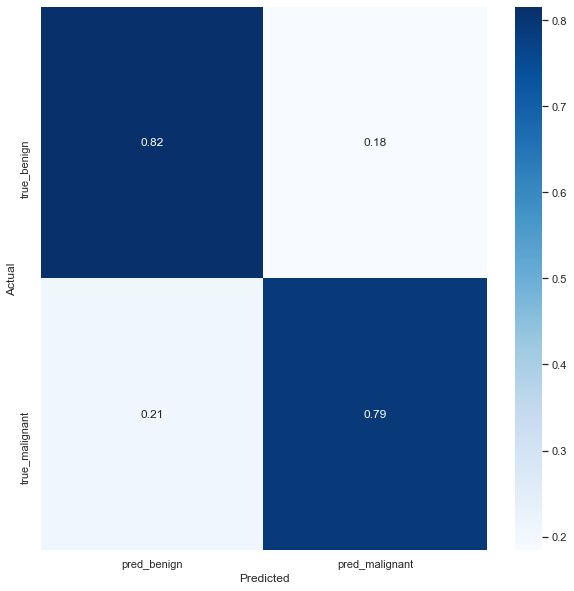

In [34]:
def plot_confusion_matrix(y_test, y_pred):
  cmn = confusion_matrix(y_test, y_pred)
  # Normalise
  cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
  # print it
  print(cmn)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', 
              xticklabels=[f"pred_{c}" for c in class_names], 
              yticklabels=[f"true_{c}" for c in class_names],
              cmap="Blues"
              )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  # plot the resulting confusion matrix
  plt.show()

plot_confusion_matrix(y_test, y_pred)

In [35]:
sensitivity = sensitivity_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


print("IDC accuracy:", accuracy)
print("IDC precision:", precision)
print("IDC recall:", recall)
print("IDC Sensitivity:", sensitivity)
print("IDC Specificity:", specificity)
print("IDC f1:", f1)

IDC accuracy: 0.8062546067179109
IDC precision: 0.7129149377593361
IDC recall: 0.789488799540494
IDC Sensitivity: 0.789488799540494
IDC Specificity: 0.8159600997506234
IDC f1: 0.7492504769692014



* Precision nos da la calidad de la predicción: ¿qué porcentaje de los que hemos dicho que son la clase positiva, en realidad lo son?

* Recall nos da la cantidad: ¿qué porcentaje de la clase positiva hemos sido capaces de identificar?

* F1 combina Precision y Recall en una sola medida

* La Matriz de Confusión indica qué tipos de errores se cometen

ROC AUC: 0.803


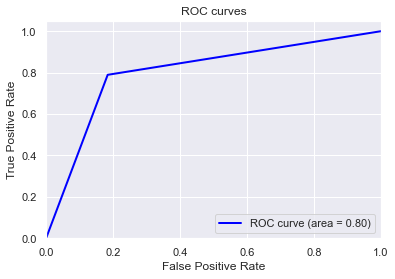

In [36]:
def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """
    # prepare for figure
    plt.figure()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    # obtain ROC AUC
    roc_auc = auc(fpr, tpr)
    # print score
    print(f"ROC AUC: {roc_auc:.3f}")
    # plot ROC curve
    plt.plot(fpr, tpr, color="blue", lw=2,
                label='ROC curve (area = {f:.2f})'.format(d=1, f=roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc(y_test, y_pred)